In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv('random_batch_18_nov_2020.csv')

# Display the head
df.head()

,repo_name,commit,message,Is_Refactor,Is_Perfective,Is_Adaptive,Is_Corrective,Justification,Comment,Certain,Sampling,Is_English,Is_Abstraction,Is_Performance,Is_Positive_Sentiment,Is_Negative_Sentiment,Is_Security,Is_Swearing
0,pymor/dune-gdt,b0c1b7037681ded5b3409fdbb9f18902684e92d9,[pylicense] add .tpl to config bump copyright ...,False,True,False,FALSE,"add, bump copyright",NaN,NaN,random_batch_18_nov_2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,wso2/carbon-analytics,ddcea4897ac24c0f71469cc5ed4846dcfe23585f,Added missing iterator\n,False,False,False,TRUE,add missing,NaN,NaN,random_batch_18_nov_2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,root-mirror/root,e41c550e9371bc246a66df25edd02fec109d67b0,win32gdk source files.\n\n\ngit-svn-id: acec3f...,False,False,False,FALSE,NaN,NaN,FALSE,random_batch_18_nov_2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,yuanming-hu/taichi,1bd17f6f1507a07b1a8896511642f72eac19843b,removed all return values of runtime initializ...,False,False,False,FALSE,removed,NaN,NaN,random_batch_18_nov_2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,otwcode/otwarchive,f96a19672775cc67940c99e5a0a3043b97a1ee29,Merge pull request #988 from tuff-ghost/issue_...,True,True,False,FALSE,rewrite,NaN,NaN,random_batch_18_nov_2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Preprocessing - Column Dropping

# Columns to drop:
    # repo_name and commit:
        # Reason: They are just identifiers and don’t provide meaningful information
    # Is_Abstraction, Is_Performance, Is_Positive_Sentiment, Is_Negative_Sentiment, Is_Security, Is_Swearing:
        # Reason: They are secondary attributes, sparsely populated and likely not very useful
    # Comment, Certain, Justification, Is_English, Sampling:
        # Reason: They are not useful and most of their rows are missing 

# Columns to keep:
    # message
        # Reason: for obvious reasons
    # Is_Refactor, Is_Perfective, Is_Adaptive, Is_Corrective:
        # Reason: They are the primary targets

label_columns = ['Is_Refactor', 'Is_Perfective', 'Is_Adaptive', 'Is_Corrective']

columns_to_drop = ['repo_name', 'commit', 'Is_Abstraction', 'Is_Performance', 'Is_Positive_Sentiment', 'Is_Negative_Sentiment', 'Is_Security', 'Is_Swearing', 'Comment', 'Certain', 'Justification', 'Is_English', 'Sampling']

df = df.drop(columns_to_drop, axis=1)
df = df.dropna(axis=0, subset=['message'])
df = df.drop_duplicates(subset=['message'])

# Convert True and False to 1 and 0, handle case differences and whitespace
for col in label_columns:
    df[col] = df[col].apply(lambda x: 1 if str(x).strip().lower() == 'true' 
                            else 0 if str(x).strip().lower() == 'false' 
                            else pd.NA)

# Confirm
df.head()

,message,Is_Refactor,Is_Perfective,Is_Adaptive,Is_Corrective
0,[pylicense] add .tpl to config bump copyright ...,0,1,0,0
1,Added missing iterator\n,0,0,0,1
2,win32gdk source files.\n\n\ngit-svn-id: acec3f...,0,0,0,0
3,removed all return values of runtime initializ...,0,0,0,0
4,Merge pull request #988 from tuff-ghost/issue_...,1,1,0,0


In [6]:
# Preprocessing - Tokenizization, Lemmatization, Removing Stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

df['message'] = df['message'].apply(preprocess_text)

# Confirm
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ahmet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahmet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ahmet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ahmet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,message,Is_Refactor,Is_Perfective,Is_Adaptive,Is_Corrective
0,pylicense add tpl config bump copyright year,0,1,0,0
1,added missing iterator,0,0,0,1
2,win32gdk source file gitsvnid acec3fd5b7ea1eb9...,0,0,0,0
3,removed return value runtime initialization fu...,0,0,0,0
4,merge pull request 988 tuffghostissue3380 3380...,1,1,0,0


In [7]:
# Separate labeled and unlabeled data
labeled_df = df.dropna(subset=label_columns, how='all')  # At least one label is present
labeled_df = labeled_df.dropna(subset=label_columns, how='any')  # Drop mixed labels, where some of the labels are NaN but others are filled

unlabeled_df = df[df[label_columns].isna().all(axis=1)]  # Completely unlabeled data

# Confirm separation
print("Labeled Data:", labeled_df.shape)
print("Unlabeled Data:", unlabeled_df.shape)

Labeled Data: (1379, 5)
Unlabeled Data: (3558, 5)


In [8]:
# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  
X = tfidf.fit_transform(labeled_df['message'])
y = labeled_df[label_columns]

In [12]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Naive bayes model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
import numpy as np


y_train = y_train.astype(int).values
y_test = y_test.astype(int).values

clf = OneVsRestClassifier(MultinomialNB())
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

threshold = 0.4
y_pred = (np.array(y_pred) >= threshold).astype(int)

# Evaluate the performance
print(classification_report(y_test, y_pred, target_names=label_columns))

               precision    recall  f1-score   support

  Is_Refactor       0.00      0.00      0.00        38
Is_Perfective       1.00      0.15      0.26        66
  Is_Adaptive       0.00      0.00      0.00        79
Is_Corrective       1.00      0.08      0.15        74

    micro avg       1.00      0.06      0.12       257
    macro avg       0.50      0.06      0.10       257
 weighted avg       0.54      0.06      0.11       257
  samples avg       0.06      0.05      0.05       257



C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMet

In [16]:
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss

f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
hamming = hamming_loss(y_test, y_pred)

print("Naive Bayes with TDIDF Metrics:")
print(f"F1-Score: {f1}, Precision: {precision}, Recall: {recall}, Hamming: {hamming}")

Naive Bayes with TDIDF Metrics:
F1-Score: 0.11077206635265205, Precision: 0.5447470817120622, Recall: 0.0622568093385214, Hamming: 0.21829710144927536


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


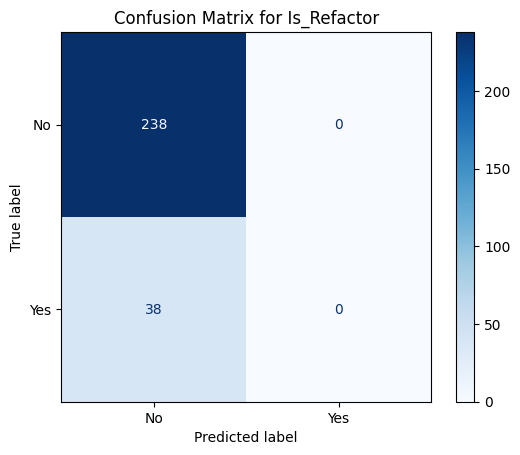

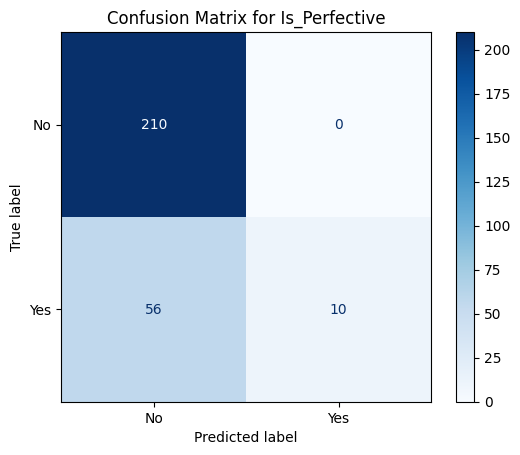

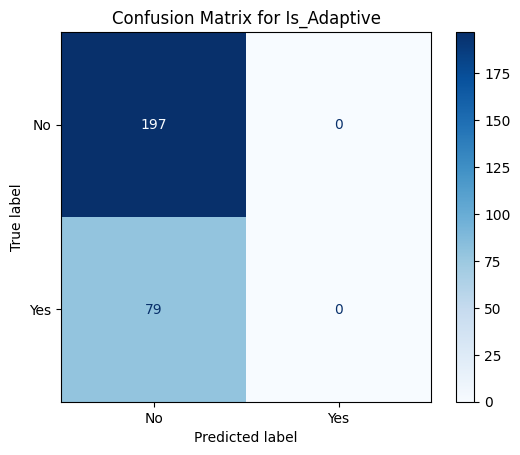

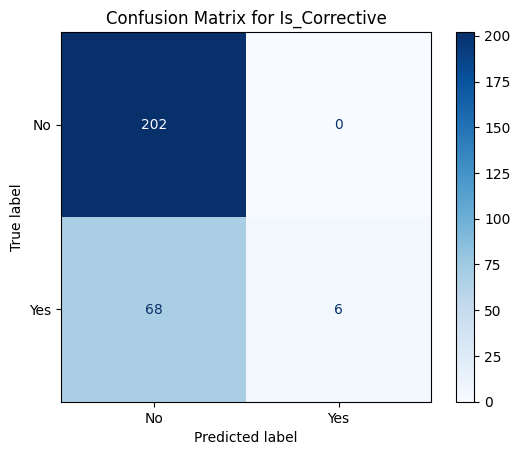

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix for each label
for idx, label in enumerate(label_columns):
    cm = confusion_matrix(y_test[:, idx], y_pred[:, idx])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for {label}")
    plt.show()

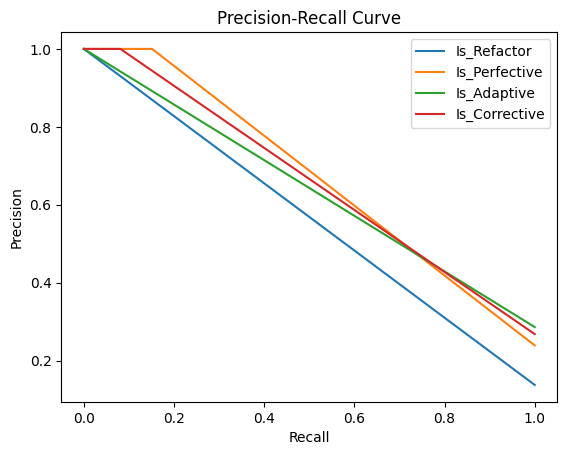

In [22]:
from sklearn.metrics import precision_recall_curve

# Plot Precision-Recall curve for each label
for idx, label in enumerate(label_columns):
    precision, recall, thresholds = precision_recall_curve(y_test[:, idx], y_pred[:, idx])
    plt.plot(recall, precision, label=f"{label}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

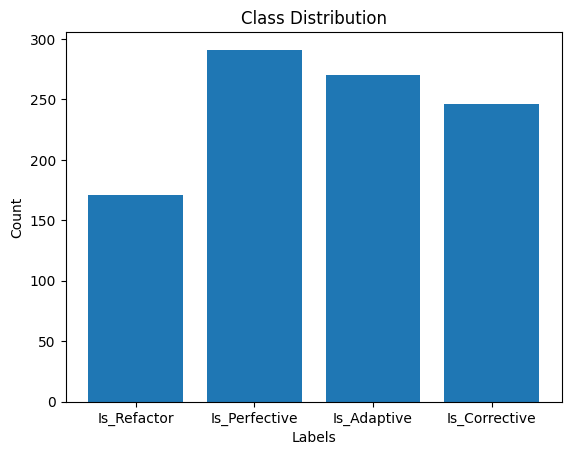

In [24]:
# Class Distribution
label_counts = y_train.sum(axis=0)  # Sum across columns for total positives per label
plt.bar(label_columns, label_counts)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

In [26]:
# Find misclassified samples
misclassified_indices = np.where(y_test != y_pred)
print("Misclassified Samples:")
for idx in misclassified_indices[0][:5]:  # Display the first 5 misclasiffied samples
    print(f"Text: {labeled_df.iloc[idx]['message']}")
    print(f"True: {y_test[idx]}")
    print(f"Predicted: {y_pred[idx]}")
    print()

Misclassified Samples:
Text: pylicense add tpl config bump copyright year
True: [0 0 0 1]
Predicted: [0 0 0 0]

Text: added missing iterator
True: [0 0 0 1]
Predicted: [0 0 0 0]

Text: merge pull request 988 tuffghostissue3380 3380 2928 rewrite ibox modal dialog plugin
True: [0 0 1 0]
Predicted: [0 0 0 0]

Text: merge pull request 818 onfidofeaturefixreadmeindentationcx4204 fix readme indentation callback
True: [0 0 1 0]
Predicted: [0 0 0 0]

Text: merge pull request 493 cdmihaicdmihaitablebuildstatus show build status table
True: [0 0 0 1]
Predicted: [0 0 0 0]

